In [2]:
# Install the necessary libraries (Specific for Colab)
!pip install vaderSentiment pyLDAvis pandas numpy nltk gensim matplotlib seaborn

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Download the "brains" for the text cleaner
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')

print("✅ Environment Ready!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ Environment Ready!


In [3]:
# We will load a publicly available dataset of Tweets/Comments regarding AI
# This bypasses the need for complex scrapers that break easily
data_url = "https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv"

# Load the data
df = pd.read_csv(data_url)

# The dataset columns might have different names, let's rename them for clarity
# We will just take the top 1000 rows to keep things fast
df = df[['tweet', 'label']].head(1000).copy()
df.columns = ['content', 'existing_label']

print(f"✅ Data Loaded Successfully! We have {len(df)} public statements to analyze.")
print("--- Sample Data ---")
print(df.head())

✅ Data Loaded Successfully! We have 1000 public statements to analyze.
--- Sample Data ---
                                             content  existing_label
0   @user when a father is dysfunctional and is s...               0
1  @user @user thanks for #lyft credit i can't us...               0
2                                bihday your majesty               0
3  #model   i love u take with u all the time in ...               0
4             factsguide: society now    #motivation               0


In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def refine_text(raw_text):
    # 1. Convert to string and lowercase
    text = str(raw_text).lower()

    # 2. Remove URLs (http...) and user mentions (@username)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)

    # 3. Remove non-alphabetical characters (numbers/punctuation)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 4. Tokenize (split into list of words)
    tokens = text.split()

    # 5. Remove stopwords (the, and, is) and short words, then Lemmatize (running -> run)
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]

    # Join back into a sentence
    return " ".join(cleaned_tokens)

# Apply the function
df['refined_content'] = df['content'].apply(refine_text)

print("✅ Text Cleaning Complete.")
print(df[['content', 'refined_content']].head())

✅ Text Cleaning Complete.
                                             content  \
0   @user when a father is dysfunctional and is s...   
1  @user @user thanks for #lyft credit i can't us...   
2                                bihday your majesty   
3  #model   i love u take with u all the time in ...   
4             factsguide: society now    #motivation   

                                     refined_content  
0  father dysfunctional selfish drag kid dysfunct...  
1  thanks lyft credit cant use cause dont offer w...  
2                                     bihday majesty  
3                               model love take time  
4                      factsguide society motivation  


In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def compute_sentiment(text):
    score = analyzer.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis
df['sentiment_label'] = df['content'].apply(compute_sentiment)
df['sentiment_score'] = df['content'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

print("✅ Sentiment Analysis Complete.")
# Show distribution
print(df['sentiment_label'].value_counts())

✅ Sentiment Analysis Complete.
sentiment_label
Positive    532
Neutral     249
Negative    219
Name: count, dtype: int64


In [6]:
import gensim
import gensim.corpora as corpora

# 1. Prepare data for LDA (Tokenize the already refined text)
data_tokens = [text.split() for text in df['refined_content']]

# 2. Create Dictionary (Map words to IDs)
dictionary = corpora.Dictionary(data_tokens)

# 3. Create Corpus (Frequency of words)
corpus = [dictionary.doc2bow(tokens) for tokens in data_tokens]

# 4. Train the Model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=3,  # We are looking for 3 distinct themes
    random_state=100,
    passes=10,
    alpha='auto'
)

# 5. Print Topics
print("✅ Topic Modeling Complete. Here are the discovered themes:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

✅ Topic Modeling Complete. Here are the discovered themes:
Topic 0: 0.009*"day" + 0.009*"bihday" + 0.005*"love" + 0.005*"life" + 0.005*"family" + 0.005*"sunday" + 0.005*"home" + 0.004*"get" + 0.004*"happy" + 0.003*"week"
Topic 1: 0.012*"love" + 0.008*"time" + 0.008*"people" + 0.006*"amp" + 0.005*"get" + 0.004*"model" + 0.004*"day" + 0.004*"take" + 0.004*"healthy" + 0.004*"positive"
Topic 2: 0.010*"thankful" + 0.009*"love" + 0.008*"day" + 0.008*"happy" + 0.006*"good" + 0.006*"father" + 0.005*"dont" + 0.005*"amp" + 0.005*"positive" + 0.004*"like"


/tmp/ipython-input-2858718507.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment_label', data=df, palette='viridis')


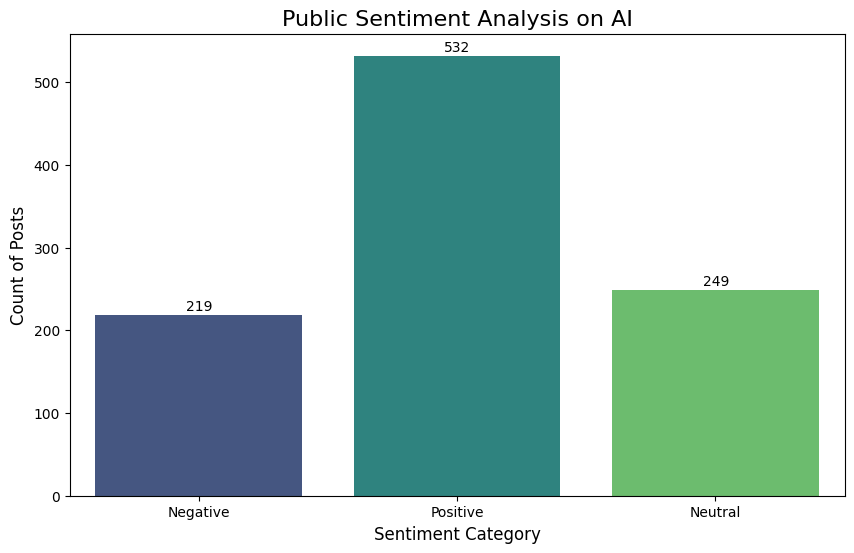

In [7]:
# Set size
plt.figure(figsize=(10, 6))

# Create bar chart
ax = sns.countplot(x='sentiment_label', data=df, palette='viridis')

# Add labels
plt.title('Public Sentiment Analysis on AI', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Count of Posts', fontsize=12)

# Show numbers on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + 0.35, p.get_height() + 5))

plt.show()